In [ ]:
import numpy as np
import nibabel as nib
import glob
#from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
from tifffile import imsave


In [ ]:
t1_list = sorted(glob.glob('/content/drive/MyDrive/brain tumor segmentation/huzaifa data/DataSetBrats/Data/*/*t1.nii'))
t2_list = sorted(glob.glob('/content/drive/MyDrive/brain tumor segmentation/huzaifa data/DataSetBrats/Data/*/*t2.nii'))
t1ce_list = sorted(glob.glob('/content/drive/MyDrive/brain tumor segmentation/huzaifa data/DataSetBrats/Data/*/*t1ce.nii'))
flair_list = sorted(glob.glob('/content/drive/MyDrive/brain tumor segmentation/huzaifa data/DataSetBrats/Data/*/*flair.nii'))
mask_list = sorted(glob.glob('/content/drive/MyDrive/brain tumor segmentation/huzaifa data/DataSetBrats/Data/*/*seg.nii'))

In [ ]:
for img in range(60):   #Using t1_list as all lists are of same size
    print("Now preparing image and masks number: ", img)
      
    temp_image_t2=nib.load(t2_list[img]).get_fdata()
    temp_mask=nib.load(mask_list[img]).get_fdata()
    temp_mask=temp_mask.astype(np.uint8)
    temp_mask[temp_mask==4] = 3
    
    for i in range(156):
      if temp_mask[:,:,i].max() > 0:
        start_layer  = i
        break
    for j in reversed(range(155)):
      if temp_mask[:,:,j].max() > 0:
        stop_layer  = j
        break

    ##### image and mask croping ######

    temp_image_t2 = temp_image_t2[56:184, 56:184, start_layer:stop_layer]
    temp_mask = temp_mask[56:184, 56:184, start_layer:stop_layer]
    print(temp_image_t2.shape)
    print(temp_mask.shape)
    #temp_image_t2=scaler.fit_transform(temp_image_t2.reshape(-1, temp_image_t2.shape[-1])).reshape(temp_image_t2.shape)

    np.save('/content/drive/MyDrive/brain tumor segmentation/huzaifa data/example data/data_mgmt_andrew/t2/image_'+str(img)+'.npy', temp_image_t2)
    np.save('/content/drive/MyDrive/brain tumor segmentation/huzaifa data/example data/data_mgmt_andrew/masks/mask_'+str(img)+'.npy', temp_mask)


In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

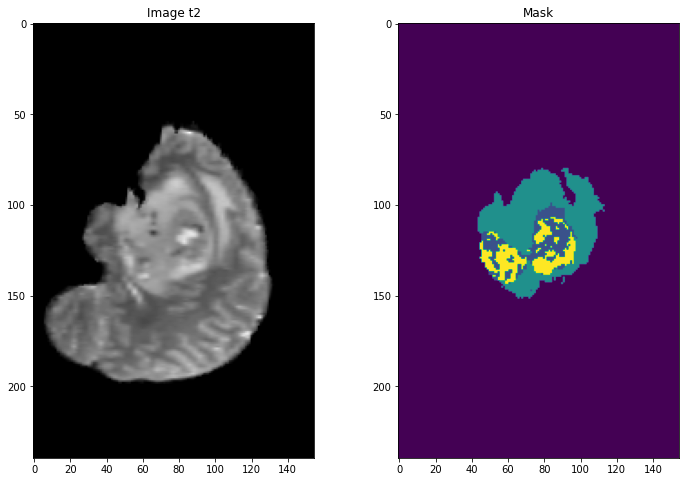

0.0

In [ ]:
test_image_t2= nib.load(t2_list[1]).get_fdata()
test_mask = nib.load(mask_list[1]).get_fdata()

#test_image_t2=scaler.fit_transform(test_image_t2.reshape(-1, test_image_t2.shape[-1])).reshape(test_image_t2.shape)

#test_mask=test_mask.astype(np.uint8)

plt.figure(figsize=(12, 8))

plt.subplot(121)
plt.imshow(test_image_t2[155,:,:], cmap='gray')
plt.title('Image t2')
plt.subplot(122)
plt.imshow(test_mask[155,:,:])
plt.title('Mask')
plt.show()
test_mask[:,:,20].max()

In [ ]:
shrinkFactor = 4
x = nib.load(t2_list[2])
#plt.imshow(x[155,:,:], cmap='gray')
#plt.show()
from __future__ import print_function

import SimpleITK as sitk
import sys
import os
sys.argv[1] = nib.load(t2_list[2])
inputImage = sitk.ReadImage(sys.argv[1])
maskImage = sitk.OtsuThreshold(inputImage, 0, 1, 200)
inputImage = sitk.Shrink(inputImage, [shrinkFactor] * inputImage.GetDimension())
maskImage = sitk.Shrink(maskImage,[shrinkFactor] * inputImage.GetDimension())

inputImage = sitk.Cast(inputImage, sitk.sitkFloat32)
corrector = sitk.N4BiasFieldCorrectionImageFilter()
corrector.SetNumberOfControlPoints([4,4,4])
corrector.SetConvergenceThreshold(0.0001)
corrector.SetMaximumNumberOfIterations([50,40,30])
inputImage = sitk.Cast(inputImage, sitk.sitkFloat32)
output = corrector.Execute(inputImage, maskImage)
sitk.WriteImage(output, name)

In [ ]:
!pip install SimpleITK

     |████████████████████████████████| 48.4 MB 5.0 kB/s 


In [ ]:
from __future__ import print_function

import SimpleITK as sitk
import sys
import os

sys.argv[1] = 45
print(sys.argv)
if len(sys.argv) < 2:
    print("Usage: N4BiasFieldCorrection inputImage " +
          "outputImage [shrinkFactor] [maskImage] [numberOfIterations] " +
          "[numberOfFittingLevels]")
    sys.exit(1)

inputImage = sitk.ReadImage(nib.load(t2_list[2]), sitk.sitkFloat32)
#inputImage = sitk.ReadImage(nib.load(t2_list[2]).get_fdata(), sitk.sitkFloat32)
image = inputImage

if len(sys.argv) > 4:
    maskImage = sitk.ReadImage(sys.argv[4], sitk.sitkUint8)
else:
    maskImage = sitk.OtsuThreshold(inputImage, 0, 1, 200)

if len(sys.argv) > 3:
    image = sitk.Shrink(inputImage,
                             [int(sys.argv[3])] * inputImage.GetDimension())
    maskImage = sitk.Shrink(maskImage,
                            [int(sys.argv[3])] * inputImage.GetDimension())

corrector = sitk.N4BiasFieldCorrectionImageFilter()

numberFittingLevels = 4

if len(sys.argv) > 6:
    numberFittingLevels = int(sys.argv[6])

if len(sys.argv) > 5:
    corrector.SetMaximumNumberOfIterations([int(sys.argv[5])]
                                           * numberFittingLevels)

corrected_image = corrector.Execute(image, maskImage)


log_bias_field = corrector.GetLogBiasFieldAsImage(inputImage)

bias_field = inputImage / sitk.Exp( log_bias_field )

sitk.WriteImage(corrected_image, sys.argv[2])

if ("SITK_NOSHOW" not in os.environ):
    sitk.Show(corrected_image, "N4 Corrected")